In [1]:
%matplotlib widget
import numpy as np

import SimpleITK as sitk
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

import torch
from segment_anything import sam_model_registry

from utils.demo import BboxPromptDemo

## Load pre-trained model

In [2]:
medsam_ckpt_path = "work_dir/MedSAM/medsam_vit_b.pth"
device = "cuda:0"

medsam_model = sam_model_registry['vit_b'](checkpoint=medsam_ckpt_path)
medsam_model = medsam_model.to(device)
medsam_model.eval()

bbox_prompt_demo = BboxPromptDemo(medsam_model)

# Original Demo

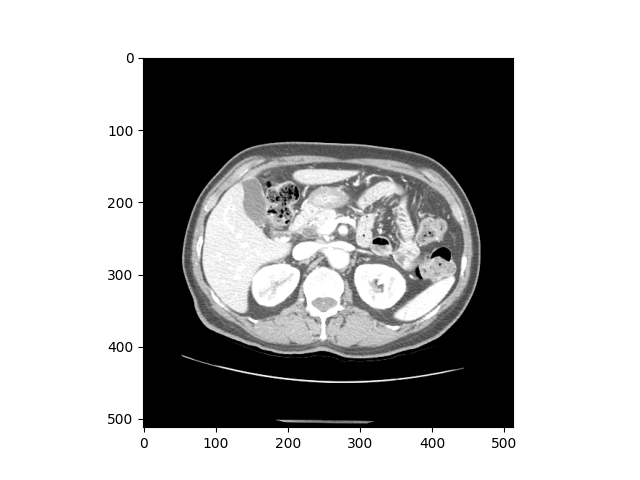

Text(0.5, 1.0, 'middle slice:46')

In [3]:
# load demo nii data
demo_file_nii = "work_dir/FLARE22_Tr_0046_0000.nii.gz"
file_sitk = sitk.ReadImage(demo_file_nii)
image_data = sitk.GetArrayFromImage(file_sitk) #slice first, then x, y
# adjust window width and level
lower_bound = -240.0
upper_bound = 160.0
image_data_pre = np.clip(image_data, lower_bound, upper_bound)
# normalise to [0, 255]
image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
image_data_pre = np.uint8(image_data_pre)
# select middle slice; you can also manually select the slice that you want to test
image_slice_id = int(image_data_pre.shape[0]/2)
image_slice = image_data_pre[image_slice_id]
# show the image to check whether it contains abdominal organs
plt.imshow(np.rot90(image_slice, 2), cmap='grey')
plt.show()
plt.title('middle slice:'+str(image_slice_id))

Set 2D image with shape: (512, 512)


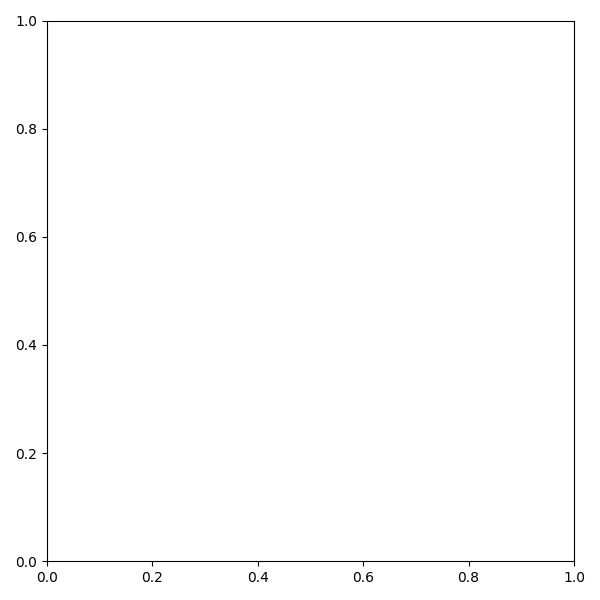

In [4]:
bbox_prompt_demo.set_image(image_slice)
bbox_prompt_demo.show()

# Let's try on our data

### F20204 Liver ShMoLLI

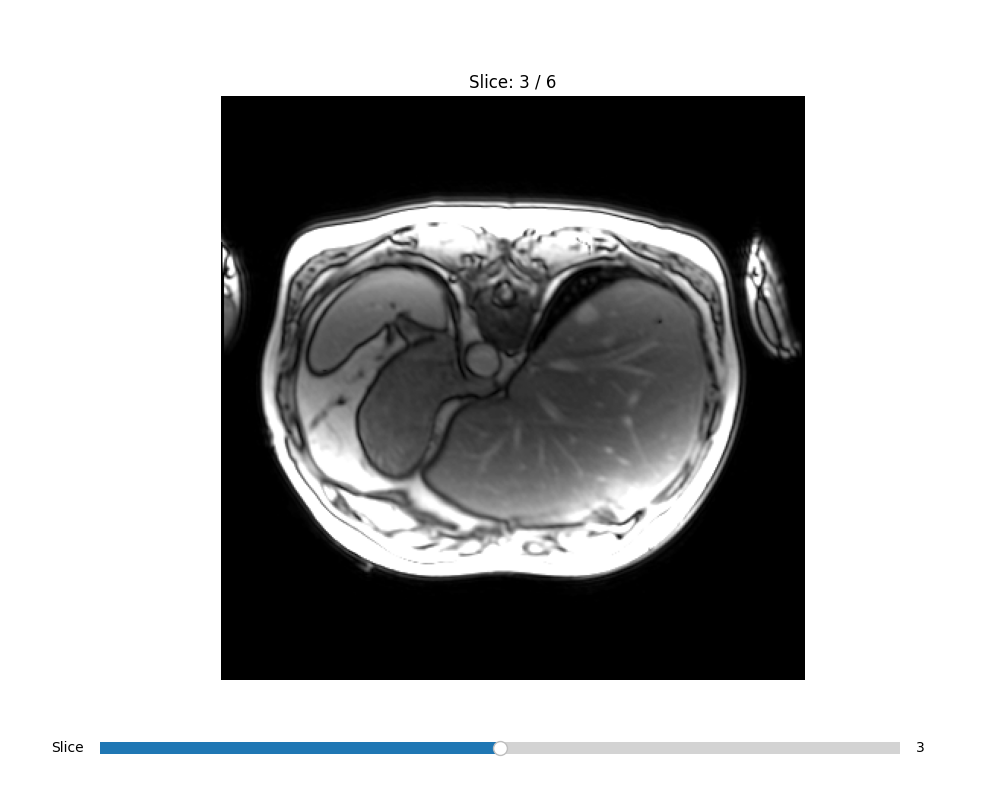

In [5]:
pth = "/group/glastonbury/soumick/toysets/dummy_F20204_Liver_Imaging_T1_ShMoLLI_DICOM_H5v3/exported_images/NIFTI/4466184_20204_2_0_primary_0.nii.gz"

file_sitk = sitk.ReadImage(pth)
image_data = sitk.GetArrayFromImage(file_sitk) #channel (or slice in 3D cases) first, then x, y

# Check if the last 2 dimensions are not identical and pad to make it a perfect square
height, width = image_data.shape[-2], image_data.shape[-1]
if height != width:
    # Calculate padding needed to make it square
    max_dim = max(height, width)
    pad_height = max_dim - height
    pad_width = max_dim - width
    
    # Apply padding to the last two dimensions
    if len(image_data.shape) == 2:
        # 2D image
        image_data = np.pad(image_data, 
                            ((pad_height//2, pad_height - pad_height//2), 
                            (pad_width//2, pad_width - pad_width//2)), 
                            mode='constant', constant_values=0)
    elif len(image_data.shape) == 3:
        # 3D image (multiple slices)
        image_data = np.pad(image_data, 
                            ((0, 0), 
                            (pad_height//2, pad_height - pad_height//2), 
                            (pad_width//2, pad_width - pad_width//2)), 
                            mode='constant', constant_values=0)

# normalise to [0, 255]

# # Method 0: Simple normalisation with Min/Max scaling
# image_data_pre = (image_data - np.min(image_data))/(np.max(image_data)-np.min(image_data))*255.0
# image_data_pre = np.uint8(image_data_pre)

# Method 1: Window/Level adjustment (like CT/MRI viewing)
lower_percentile = 1
upper_percentile = 95
lower_bound = np.percentile(image_data[image_data > 0], lower_percentile) if np.any(image_data > 0) else 0
upper_bound = np.percentile(image_data, upper_percentile)
image_data_windowed = np.clip(image_data, lower_bound, upper_bound)
image_data_pre = (image_data_windowed - lower_bound) / (upper_bound - lower_bound) * 255.0
image_data_pre = np.uint8(image_data_pre)

# Check if this is a 3D image (multiple slices) or 2D
if len(image_data_pre.shape) > 2 and image_data_pre.shape[0] > 1:
    # Multiple slices - create interactive slider plot
    
    # Close any existing figures to avoid conflicts
    plt.close('all')
    
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.subplots_adjust(bottom=0.15)
    
    # Initial slice (middle)
    image_slice_id = int(image_data_pre.shape[0]/2)
    image_slice = image_data_pre[image_slice_id]
    
    # Display initial image
    im = ax.imshow(np.rot90(image_slice, 2), cmap='gray', vmin=0, vmax=255)
    ax.set_title(f'Slice: {image_slice_id} / {image_data_pre.shape[0]-1}')
    ax.axis('off')
    
    # Create slider
    ax_slider = plt.axes([0.1, 0.05, 0.8, 0.03])
    slider = Slider(ax_slider, 'Slice', 0, image_data_pre.shape[0]-1, 
                   valinit=image_slice_id, valfmt='%d', valstep=1)
    
    def update_slice(val):
        slice_idx = int(slider.val)
        current_slice = image_data_pre[slice_idx]
        im.set_array(np.rot90(current_slice, 2))
        im.set_clim(vmin=0, vmax=255)
        ax.set_title(f'Slice: {slice_idx} / {image_data_pre.shape[0]-1}')
        plt.draw()
    
    slider.on_changed(update_slice)
    plt.show()
    
    # Set the current slice for later use
    image_slice_id = int(image_data_pre.shape[0]/2)
    image_slice = image_data_pre[image_slice_id]
else:
    # Single slice - display normally
    plt.close('all')
    
    if len(image_data_pre.shape) == 3:
        image_slice = image_data_pre[0]
        image_slice_id = 0
    else:
        image_slice = image_data_pre
        image_slice_id = 0
    
    plt.figure(figsize=(10, 8))
    plt.imshow(np.rot90(image_slice, 2), cmap='gray')
    plt.title(f'Image slice: {image_slice_id}')
    plt.axis('off')
    plt.show()


Set 2D image with shape: (384, 384)


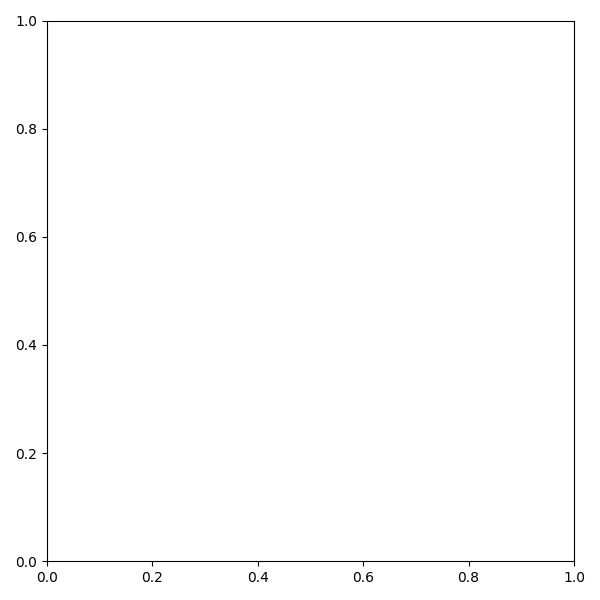

In [6]:
# 2D segmentation, only the central slice (original)
bbox_prompt_demo.set_image(image_slice)
bbox_prompt_demo.show()

Set 3D volume with shape: (7, 384, 384)
Computing embeddings for all slices...
Computed embeddings for 7 slices.


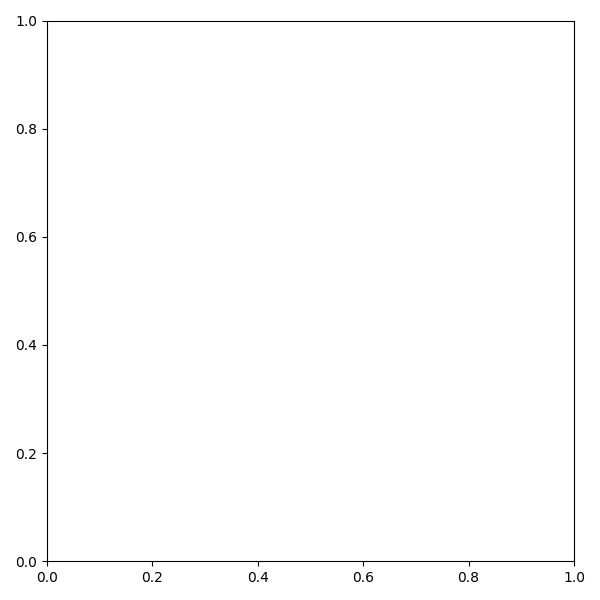

: 

In [ ]:
# 3D segmentation, extended functionality
bbox_prompt_demo.set_image(image_data_pre)
bbox_prompt_demo.show()